In [1]:
# Miscellaneous
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Libraries for NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# custom methods
from utils import category_ngram, plot_history, plot_cmatrix, display_wordcloud, aut_frequency, plot_bars_authors

# Others
import os
import re

# Seaborn style
sns.set_style('whitegrid')
# Matplot style 
plt.style.use('ggplot')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sherlock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Dataset Description

The file contains 202,372 records. Each json record contains following attributes:

-  `category`: Category article belongs to
-  `headline`: Headline of the article 
-  `authors`: Person authored the article
-  `link`: Link to the post
-  `short_description`: Short description of the article
-  `date`: Date the article was published

The next step is to load the dataset

In [2]:
# Loading the dataset
news_category = pd.read_json('dataset/News_Category_Dataset_v2.json', lines=True)
print(news_category.shape)
news_category.head()

(200853, 6)


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


This dataset contains a total of 6 features and 200853 samples.

For a further dig into the dataset, the function ``describe`` of pandas is used. There we can see samples the number of unique categories which are 41. Additionally, It is possible to see that there are repeated headlines, authord and short_descriptions. The last information will be used to filter the dataset.

In [3]:
# Describe info of the dataset
news_category.describe()

<ipython-input-3-c99a2d68ffff>:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttps://www.publ...,,2013-01-17 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


Another important step is to check for Null or NaN values. Although it was already seen with the `describe` method that there is not NaN, The following cell prints the sum of NaN in the dataset.

In [4]:
# Checking for NaNs
news_category.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

The next cell prints all the categories within the dataset, this is a very good insight about the number of categories and their names.

In [5]:
# Print unique categories
print('The Categories in the dataset are: \n')
print(news_category.category.unique())
print('The total number of features are: {}'.format(len(news_category.category.unique())))

The Categories in the dataset are: 

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']
The total number of features are: 41


To following cell prints a short description's example.

In [6]:
print('A short description: {}'.format(news_category.iloc[7]["short_description"]))

A short description: There's a great mini-series joining this week.


## Visualizing data

To gain more insights about the dataset, I will plot the number of samples belonging to an specific category in a barplot. This will plot will show if the datasetet is balanced.

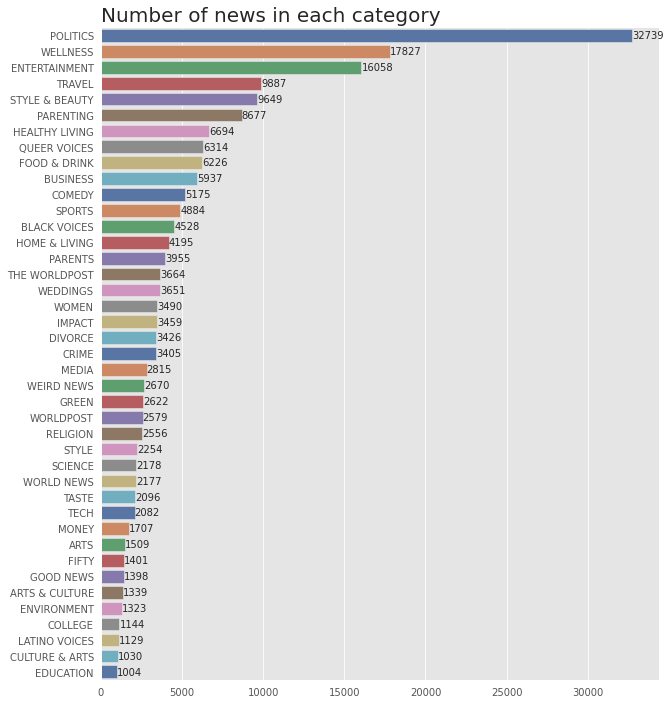

In [7]:
# Create new dataframe
bars_df = pd.DataFrame(news_category['category'].value_counts()).reset_index()
# Plotting
plt.figure(figsize=(10, 12))
bars = sns.barplot(data = bars_df, y = 'index', x = 'category', palette='deep')
plt.title('Number of news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
ax = bars
# Adding values in each bar 
# https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
    
plt.show()

From the last plot we can see that the `category` "Politics" is the most common one in the dataset. Moreover, the category with less samples is `Education`, however, it seems to be a reasonable value to train a neural network. The last Barplot give us considerable good insights about what are the most frequent categories.

Another interesting insight would be the average lenght of the `headlines` and `descriptions` in the dataset, to do so, a probability, dense function will be plotted for each of these features.

In [8]:
# Use plotly to see the distribution of categorical data
fig = ff.create_distplot([news_category['headline'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Headline lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of a headline",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500)
plotly.offline.plot(fig, filename = 'headline.html')

'headline.html'

Similarly, it is also possible to plot the lenght of the `short_description`.

In [9]:
# Use plotly to see the distribution of categorical data
# https://www.kaggle.com/vikashrajluhaniwal/recommending-news-articles-based-on-read-articles#6.-Headline-based-similarity-on-new-articles
fig = ff.create_distplot([news_category['short_description'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Description lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of Description",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500)
plotly.offline.plot(fig, filename = 'short_description.html')

'short_description.html'

From the past two plots it is possible to see that the text's lenght in the `headline` and in the `short_description` are quite different. Generally, the text in the descripwion is way longer and may provide more information for a classification task.

## Filtering the dataset

The following cells will be used to filter the text within the `headline` and `short_description` features. 

These lines of code are for testing purpose, and filter the dataset based on the most recent data. The resulting dataset will be stored in a different dataframe called `news_articles`.

In [10]:
# Filter dataset by date
f_articles = news_category[news_category['date'] >= pd.Timestamp(2017,5,5)]
#f_articles = news_category.copy()
print('The shape of the filtered dataset is: {}'.format(f_articles.shape))

The shape of the filtered dataset is: (27487, 6)


One Dwarback from the past lines are that the dataset now has less categories. To validate this, the next cell prints the new list of categories.

In [11]:
# Print unique categories
print('The Categories in the dataset are: \n')
print(f_articles.category.unique())
print('The total number of features are: {}'.format(len(f_articles.category.unique())))

The Categories in the dataset are: 

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS']
The total number of features are: 28


An important step is to remove headlines and descriptions with less than five words. Additionally, as mentioned before there are repeated headlines and short descriptions, an important step is to remove these repeated texts.

In [12]:
# Filter headlines with less than 5 characters
f_articles = f_articles[f_articles['headline'].apply(lambda x: len(x.split())>5)]
f_articles = f_articles[f_articles['short_description'].apply(lambda x: len(x.split())>5)]
# Filter headlines in a descending manner
f_articles.sort_values('headline',inplace=True, ascending=False)
# Make a copy of the dataset
duplicated_headlines_series = f_articles.duplicated('headline', keep = False)
# Remove repeated headlines 
news_articles = f_articles[~duplicated_headlines_series]
# Make another copy of the dataset
duplicated_description_series = f_articles.duplicated('short_description', keep = False)
# Remove repeated descriptions 
news_articles = f_articles[~duplicated_description_series]
print("Total number of articles after removing duplicates (headlines):", f_articles.shape[0])

Total number of articles after removing duplicates (headlines): 24274


In [13]:
print("Total number of articles : ", f_articles.shape[0])
print("Total number of authors : ", f_articles["authors"].nunique())
print("Total number of unqiue categories : ", f_articles["category"].nunique())

Total number of articles :  24274
Total number of authors :  3922
Total number of unqiue categories :  28


It is interesting thing to visualize is the number of articles per date, the next cell shows the aforementioned.

In [14]:
# Articles per month
news_articles_per_month = f_articles.resample('m', on = 'date')['category'].count()
news_articles_per_month

date
2017-05-31    2006
2017-06-30    2273
2017-07-31    2129
2017-08-31    2254
2017-09-30    2027
2017-10-31    2084
2017-11-30    1934
2017-12-31    1765
2018-01-31    1856
2018-02-28    1543
2018-03-31    1652
2018-04-30    1480
2018-05-31    1271
Freq: M, Name: category, dtype: int64

Now is time to remove the stopwords, as this is a dataset in English, I will use the stopwords provided in the library `stopwords`

In [15]:
# remove stop words
stop_words = set(stopwords.words('english'))
# List of stopwords to filter
print(stop_words)

{'be', 'into', 'the', 's', 'itself', 'this', 'after', 'hadn', "needn't", 'both', 'weren', 'needn', 'were', 'only', 'above', "couldn't", 'wouldn', 'on', 'his', "you'll", 'over', 'yours', 'wasn', 'have', 'being', 'here', 'ours', 'your', 'just', 'whom', 'so', "wasn't", 'y', 'at', 'there', 'again', 't', 'each', 'once', 'mustn', "isn't", 'doing', 'o', 'won', 'some', 'i', 'he', 'd', 'll', 'ain', 'ourselves', 'own', 'off', 'them', 'did', 'himself', 'him', 'haven', 'because', 'few', 'couldn', 'aren', 'themselves', 'of', 'very', 'should', 'm', "you're", 'hers', 'before', 'shouldn', 'more', 'for', 'nor', 'to', 'same', 'doesn', "mightn't", 'until', "don't", 'herself', 'not', "it's", 'me', 'too', "wouldn't", "aren't", "hasn't", 'against', 'how', 'had', 'further', 'from', 'when', 'hasn', 'about', 'her', 'while', 'but', "doesn't", 'myself', 'which', 'these', 'she', 'most', 'don', "shouldn't", 'with', "she's", 'it', 'am', 'are', 'a', 'their', 'in', 'its', 'all', "you've", "mustn't", 'you', 'what', 'i

The following functions are used to create some filters for the dataset. The method `remove_stopwords` is used to remove stop words, `alpha_num` removes any character that is not alphanumeric, finally, rem_lemmatizer converts the words to its base form. These three basic filters are very extremely useful when processing text within a dataset and can considerable improve performance.

In [16]:
# Removing stopwords
def remove_stopwords(text):
    final_text = []
    # Split text
    for i in text.split():
        # Check if word is not in stopword, otherwise do not append
        if i.strip().lower() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

In [17]:
# Remove non alphanumeric characters
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

In [18]:
# Lemmatize words to its base form
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
lemmatizer = WordNetLemmatizer()
def rem_lemmatizer(text):
    final_text = []
    string_l = ""
    for w in word_tokenize(text):
        string_l += lemmatizer.lemmatize(w, pos = "v") + " "
    final_text.append(string_l.strip())
    return " ".join(final_text)

Once our filters are defined it is time to apply it to the dataset to the `headline`, `short_description` and `category` features. One step that is doing inplace is to convert all the caracters to lowercase. When the dataset is showed, it is possible to validate how all the filters are successfully applied.

In [19]:
# Headline filtering
# Lowercase
f_articles['headline'] = f_articles['headline'].str.lower()
# Remove stopwords
f_articles['headline'] = f_articles['headline'].apply(remove_stopwords)
# Remove non alphanumerics
f_articles['headline'] = f_articles['headline'].apply(alpha_num)
# Lemmatizer
f_articles['headline'] = f_articles['headline'].apply(rem_lemmatizer)

# Description filtering
f_articles['short_description'] = f_articles['short_description'].str.lower()
f_articles['short_description'] = f_articles['short_description'].apply(remove_stopwords)
f_articles['short_description'] = f_articles['short_description'].apply(alpha_num)
f_articles['short_description'] = f_articles['short_description'].apply(rem_lemmatizer)
# Category (lowercase)
f_articles['category'] = f_articles['category'].str.lower()

f_articles.head()

,category,headline,authors,link,short_description,date
21194,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18
2932,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02
25186,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31
26210,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19
20973,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20


To simplify the problem the `headline` and `short_description` text are blended together and used as a unified feature. This new feature is called `full_text`.

In [20]:
# Combining text
f_articles["full_text"] = f_articles["headline"].map(str) + " " + f_articles["short_description"]
f_articles.head()

,category,headline,authors,link,short_description,date,full_text
21194,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18,to bone didnt teach glamour teach respect ofte...
2932,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02,will grace creator donate gay bunny book every...
25186,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31,we blood invisible live indias dalit women gir...
26210,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19,wannacry ransomware attack raise alarm bell ci...
20973,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20,walk dead reportedly cancel comiccon press eve...


An example of how the full text looks like is shown below.

In [21]:
print('The fused text is: {}'.format(f_articles.iloc[0]["full_text"]))

The fused text is: to bone didnt teach glamour teach respect oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance


It is also important to see the most common words based on a particle category, to do so, the following cell shows a table with this information.

In [22]:
category_ngram('politics', 1, f_articles, 'category', 'headline')

,index,frequency
0,trump,3228
1,say,609
2,donald,549
3,gop,452
4,house,423
5,white,367
6,us,357
7,new,333
8,health,305
9,bill,296


Convert the text into numpy arrays for the classification task.

In [23]:
# Targets
seq_text = np.array([text for text in f_articles['full_text']])
# Labels
labels = np.array([label for label in f_articles['category']])

Now we will print the shape of `seq_text` which should has dimensions equal to the number of samples and an example

In [24]:
# Printing the shape and a text 
print(seq_text.shape)
print(seq_text[0])

(24274,)
to bone didnt teach glamour teach respect oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance


### Encoding the data

Now comes one of the most important steps and this is the encoding of the labels. As the Labels of this problem are categorical, we need to create a numeric representation. To do so, `sklearn` is used.

In [25]:
# Encoding categories
label_encoder = LabelEncoder()
# Fir the encoder
labels = label_encoder.fit_transform(labels)

The lenght of the labels must match the lenght of the catories. This information is verifies below. 

In [26]:
print('The lenght of the labels are: {}'.format(len(np.unique(labels))))
print('The labels are: {}'.format(np.unique(labels)))

The lenght of the labels are: 28
The labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


The following lines define the model's parameters overall these are given as follows.

-  vocab_size: the lenght of the vocabulary
-  embedding_dim: The size of the embedding dimension
-  max_length: The maximum lenght of the tokenize word
-  padding_type: Where to pad the vector, after or before
-  oov_tok: Token used to replace out-of-vocabulary of the words

In [27]:
# Parameters
# Size of the vocabulary
vocab_size = 2000
# Dimmension of the embedding 
embedding_dim = 128
# LSTM dim
lstm_dim = 32
# hidden dim (fully connected)
hidden_dim = 64
# Maximum lenght of the tokenized vector
max_length = 120
# Padd the vector after the sequence
padding_type ='post'
# Used to replace out-of-vocabulary words
oov_tok = "<OOV>"

Here is the `train_test_split` of the dataset to have a validation dataset

In [28]:
# split the dataset
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(seq_text, labels, 
                                                                                          test_size=0.33, 
                                                                                          stratify=labels)

In [29]:
print('The lenght of the training set is: {}'.format(train_sentences.shape))
print('The lenght of the validation set is: {}'.format(validation_sentences.shape))

The lenght of the training set is: (16263,)
The lenght of the validation set is: (8011,)


Here is where the magic happens and the words are tokenized. To do so, Keras' Tokenizer method is used. This method will automatically create the tokenized vectors with a specified lengh, padding method, etc.

In [30]:
# Transform text into a vector
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fir to the train sequence
tokenizer.fit_on_texts(train_sentences)
# Dictionary with the index of each word
word_index = tokenizer.word_index

# Transform train dataset to sequence 
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# Pad the sequence to the desired shape (given above)
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)

# Vectorize and Padd validation dataset
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen = max_length)

In [31]:
print('The shape of the tokenized dataset is: {}'.format(validation_padded.shape))

The shape of the tokenized dataset is: (8011, 120)


From above we can see that the tokenized vector has the desired lenght.

### Defining and training the model


Here is defined a simple model to classify the categories in the dataset. Recall that the features `headline` and `short_description` were blended into one single feature called `full_text`. The objective here is to classify the category given the previuos information. 

The model defined is a neural network with one embedding layer and 2 fully connected layers. Between the Embedding and the Fully connected layers is a `GlobalAveragePooling1D` which drops the sequence dimension in the output of the Embedding layer.

As this is a multiclassification task, the crossentropy loss is used, the optimizer is adam and the metric used to evaluate the model is the accuracy. A model description is provided in the cell below.

I also defined an early stop call which stops the training if the validation loss starts decreasing.

**Note**: Below is another model with a Bidirectional RNN, so recall to just use the cell of with the model you want to use.

In [36]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Flat Dimension
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(hidden_dim * 2, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 128)          256000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 28)                3612      
Total params: 276,188
Trainable params: 276,188
Non-trainable params: 0
_________________________________________________________________
None


### Defining and training a model with a Bidirectional RNN

This implementation now has a `Bidirectional` LSTM layer. This particular layer basically makes a copy of the orinal LSTM and processes the information in backwards order. It is important to take into consideration that if the number of LSTM units are 8 the   `Bidirectional` will make a copy and therefore, we will end up with a total of 16 LSTM units.

In [32]:
# Model definition

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    # Flat Dimension
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)), # Output of LSTM is Batch x Net out x 2
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 128)          256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 28)                1820      
Total params: 303,196
Trainable params: 303,196
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# Callback for early stopping after val stop improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
num_epochs = 50
history = model.fit(train_padded, train_labels, 
                    epochs = num_epochs, verbose=2, 
                    validation_split=0.33, callbacks= [early_stop])

# Predict over the validation test
pred_val = model.predict(validation_padded)
pred_val = np.array([np.argmax(i) for i in pred_val])

Epoch 1/50
341/341 - 6s - loss: 2.2592 - accuracy: 0.4173 - val_loss: 2.0326 - val_accuracy: 0.4705
Epoch 2/50
341/341 - 5s - loss: 1.7752 - accuracy: 0.5389 - val_loss: 1.7649 - val_accuracy: 0.5448
Epoch 3/50
341/341 - 5s - loss: 1.4601 - accuracy: 0.6146 - val_loss: 1.6942 - val_accuracy: 0.5599
Epoch 4/50
341/341 - 6s - loss: 1.2652 - accuracy: 0.6553 - val_loss: 1.6785 - val_accuracy: 0.5605
Epoch 5/50
341/341 - 5s - loss: 1.1103 - accuracy: 0.6900 - val_loss: 1.7243 - val_accuracy: 0.5620
Epoch 6/50
341/341 - 5s - loss: 0.9679 - accuracy: 0.7315 - val_loss: 1.7883 - val_accuracy: 0.5552
Epoch 7/50
341/341 - 5s - loss: 0.8427 - accuracy: 0.7654 - val_loss: 1.9029 - val_accuracy: 0.5402


As shown above, the model was successfully trained, for a deeper dive I will plot the Losses and Accuracy of the training.

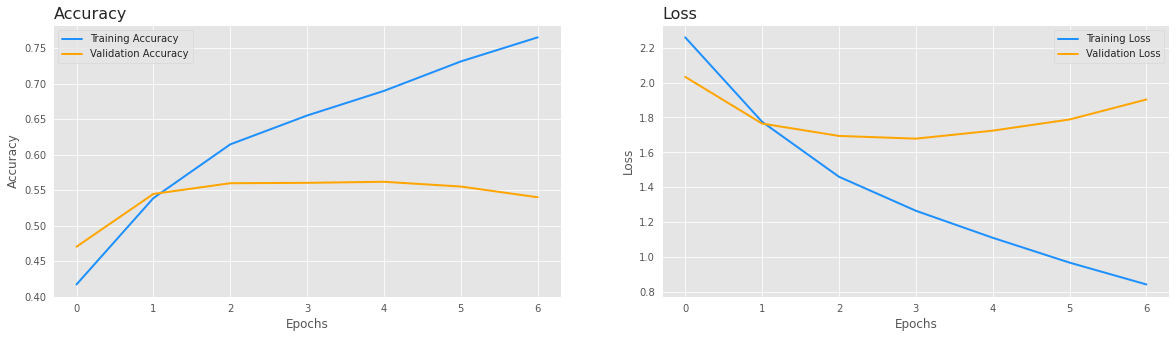

In [34]:
# Plotting the history of the model
plot_history(history)

Finally, An interesting step is to plot the confusion matrix of the validation text. This information will tell us how good the model is performing on unseen data.

The overall training accuracy is: 0.5468730495568593


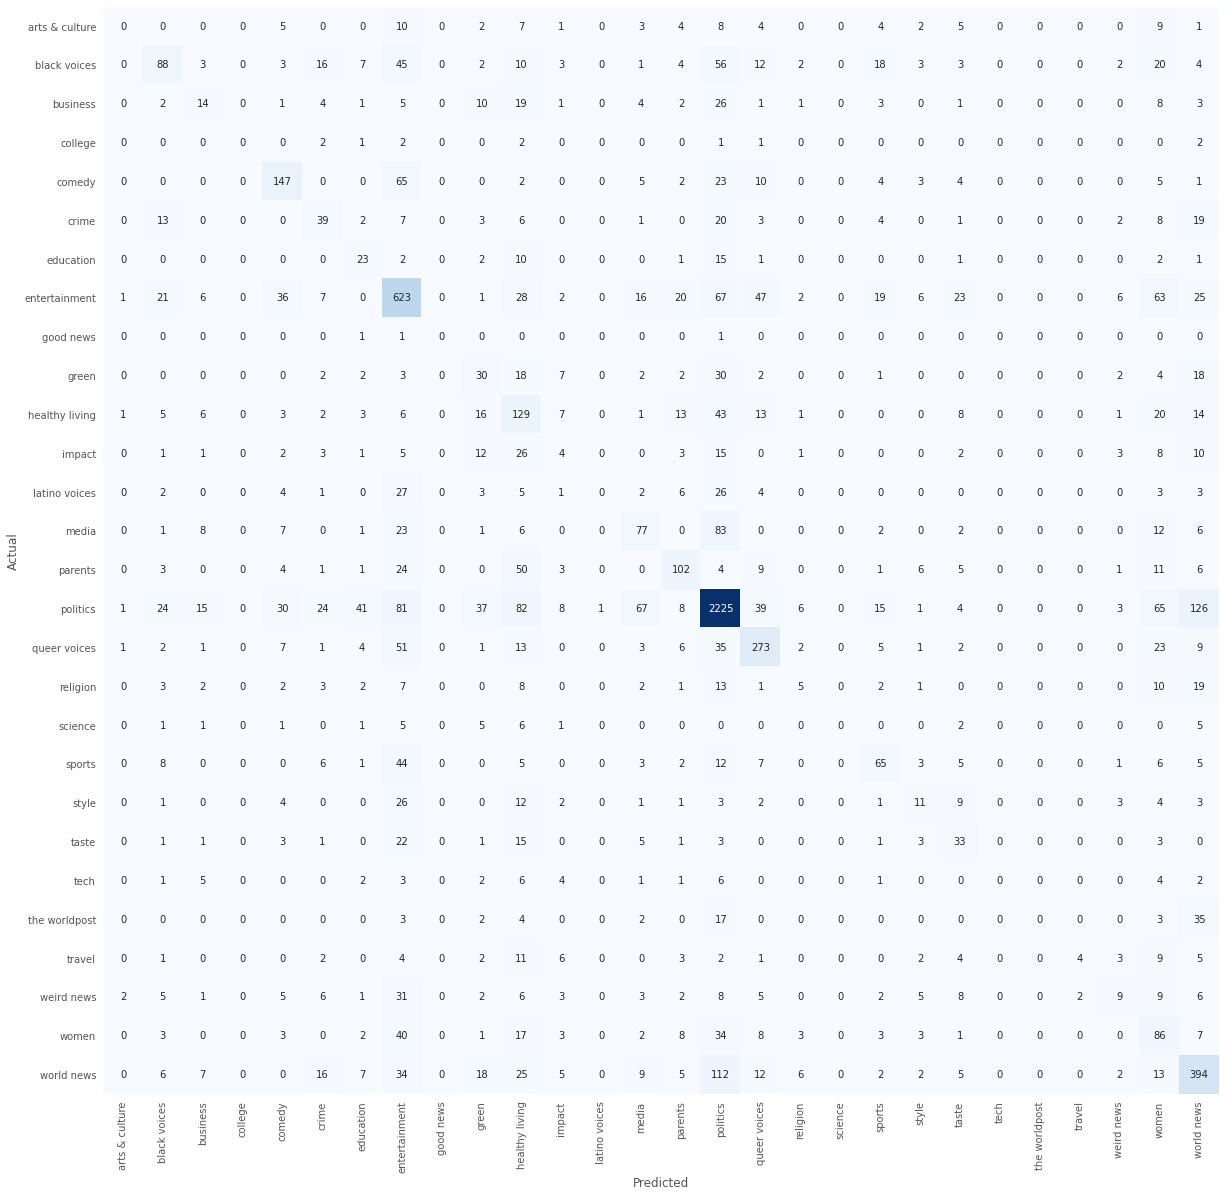

In [35]:
# Confusion matrix
# label_encoder.classes_ show the classes encoded
print('The overall training accuracy is: {}'.format(accuracy_score(pred_val, validation_labels)))
plot_cmatrix(pred_val, label_encoder.classes_, 20, validation_labels)

In [36]:
# Printing all the metrics
print(classification_report(pred_val, validation_labels, target_names = label_encoder.classes_))

                precision    recall  f1-score   support

arts & culture       0.00      0.00      0.00         6
  black voices       0.29      0.46      0.36       192
      business       0.13      0.20      0.16        71
       college       0.00      0.00      0.00         0
        comedy       0.54      0.55      0.55       267
         crime       0.30      0.29      0.30       136
     education       0.40      0.22      0.28       104
 entertainment       0.61      0.52      0.56      1199
     good news       0.00      0.00      0.00         0
         green       0.24      0.20      0.22       153
healthy living       0.44      0.24      0.31       528
        impact       0.04      0.07      0.05        61
 latino voices       0.00      0.00      0.00         1
         media       0.34      0.37      0.35       210
       parents       0.44      0.52      0.48       197
      politics       0.77      0.77      0.77      2888
  queer voices       0.62      0.60      0.61  

/home/sherlock/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Besides the last metrics, I wanted to see the number of good classifications per class, to do so the following cell print the results.

In [37]:
class_correct = list(0. for i in range(len(np.unique(labels))))
class_total = list(0. for i in range(len(np.unique(labels))))
# For loop to count the number of matches per class
for i in range(len(validation_labels)):
    # current target's label
    label = validation_labels[i]
    if validation_labels[i] == pred_val[i]:
        class_correct[label] += 1
    # Sum label
    class_total[label] += 1
        
for i in range(len(np.unique(labels))):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(label_encoder.classes_[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Accuracy of arts & culture:  0% ( 0/65)
Test Accuracy of black voices: 29% (88/302)
Test Accuracy of business: 13% (14/106)
Test Accuracy of college:  0% ( 0/11)
Test Accuracy of comedy: 54% (147/271)
Test Accuracy of crime: 30% (39/128)
Test Accuracy of education: 39% (23/58)
Test Accuracy of entertainment: 61% (623/1019)
Test Accuracy of good news:  0% ( 0/ 3)
Test Accuracy of green: 24% (30/123)
Test Accuracy of healthy living: 44% (129/292)
Test Accuracy of impact:  4% ( 4/97)
Test Accuracy of latino voices:  0% ( 0/87)
Test Accuracy of media: 33% (77/229)
Test Accuracy of parents: 44% (102/231)
Test Accuracy of politics: 76% (2225/2903)
Test Accuracy of queer voices: 62% (273/440)
Test Accuracy of religion:  6% ( 5/81)
Test Accuracy of science:  0% ( 0/28)
Test Accuracy of sports: 37% (65/173)
Test Accuracy of style: 13% (11/83)
Test Accuracy of taste: 35% (33/93)
Test Accuracy of  tech:  0% ( 0/38)
Test Accuracy of the worldpost:  0% ( 0/66)
Test Accuracy of travel:  6% ( 4/

## Second point

To analize the writing style of the authors, I will use a bag of words. With this bag of words I pretend to analize the top 10 most used words by author and thus give a insights.

First of all, I will list all the authors in the dataframe.

In [38]:
# Make a copy of the dataset
category_df = f_articles.copy()

print('The Categories in the dataset are: \n')
categories = category_df.category.unique()
print(categories)
print('The total number of features are: {}'.format(len(categories)))

The Categories in the dataset are: 

['healthy living' 'queer voices' 'world news' 'politics' 'entertainment'
 'comedy' 'black voices' 'green' 'impact' 'latino voices' 'business'
 'women' 'weird news' 'taste' 'crime' 'media' 'parents' 'travel'
 'arts & culture' 'tech' 'education' 'sports' 'religion' 'science' 'style'
 'the worldpost' 'college' 'good news']
The total number of features are: 28


Due to the inmense volume of authors in the dataset, I will use a wordCloud to show the most common authors.

In [39]:
# Counting unique items
item_counts = category_df[["category"]].value_counts(sort=True).reset_index()
# Drop annoyng index
print(item_counts[:10])

         category     0
0        politics  8797
1   entertainment  3089
2      world news  2061
3    queer voices  1332
4    black voices   916
5  healthy living   886
6          comedy   821
7         parents   699
8           media   694
9           women   678


In [40]:
cat_df = category_ngram('politics', 1, category_df, 'category', 'full_text')
cat_tuple = [tuple(x) for x in cat_df.values]
print(cat_df)

       index  frequency
0      trump       4634
1        say       1985
2  president        971
3      state        838
4     donald        833
5      house        828
6         us        780
7      white        724
8        new        721
9        gop        634


Showing a single Word cloud for a particular category

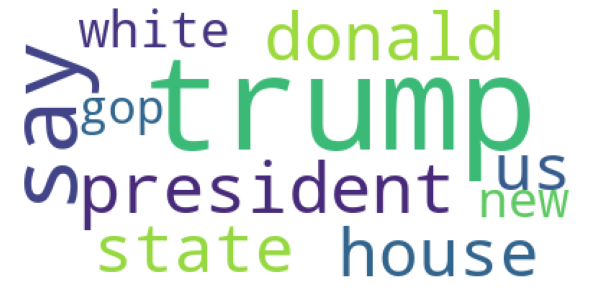

In [41]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words = 200, background_color ='white', stopwords = stop_words).generate_from_frequencies(dict(cat_tuple))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

Show wordclouds for the 12 more frequent categories

/home/sherlock/Desktop/whale_jaguar_test/utils.py:77: MatplotlibDeprecationWarning:

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.



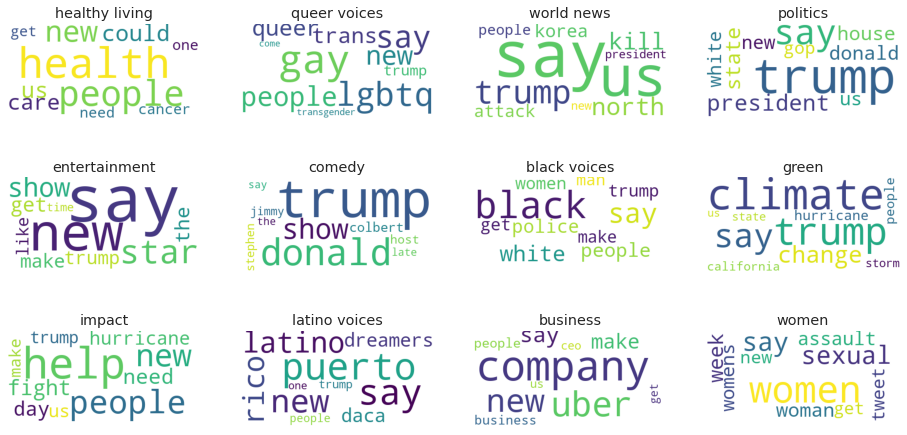

In [42]:
display_wordcloud(category_df, stop_words, 12, feature2filter = 'category', varText = 'full_text')

## Third Point

Filtering the authors

In [43]:
# Removing long sequences of authors
def trim_string(text):
    # Obtain only the first element in the authors' column
    splitted_text = text.split(',')[0]
    return splitted_text

In [44]:
# Make a copy of the dataset
authors_df = f_articles.copy().reset_index(drop=True)

authors_df['authors'] = authors_df['authors'].apply(trim_string)
# Remove empty strings
authors_df['authors'].replace('', np.nan, inplace=True)
authors_df.dropna(subset=['authors'], inplace=True)

print('The Authors in the dataset are: \n')
authors = authors_df.authors.unique()
print(authors)
print('The total number of features are: {}'.format(len(authors)))

The Authors in the dataset are: 

['Mycah Hazel' 'Elyse Wanshel' 'Sara Hylton' ... 'Phu Nguyen'
 'Emily Kalah Gade' 'Anna Sabino']
The total number of features are: 3758


In [45]:
# Count number of times an author is repeated
authors_count = authors_df[["authors"]].value_counts(sort=True).reset_index()
# Check first 10 sampples
print(authors_count[:10])

               authors    0
0            Lee Moran  906
1       Mary Papenfuss  601
2             Ed Mazza  576
3           Ron Dicker  554
4       Curtis M. Wong  427
5       Jenna Amatulli  393
6           David Moye  386
7      Rebecca Shapiro  327
8  Dominique Mosbergen  321
9          Doha Madani  298


/home/sherlock/Desktop/whale_jaguar_test/utils.py:77: MatplotlibDeprecationWarning:

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.



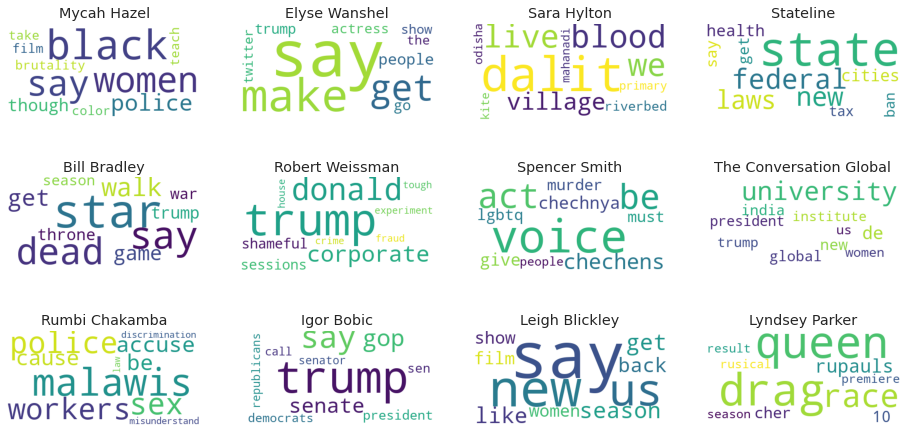

In [46]:
# WordCloud for the top 12 most common authors
display_wordcloud(authors_df, stop_words, 12, feature2filter = 'authors', varText = 'full_text')

In [47]:
# Displaying common words of 'Mary Papenfuss' and frequency
aut_df = category_ngram('Mary Papenfuss', 1, authors_df, 'authors', 'full_text')
aut_df

,index,frequency
0,trump,307
1,say,209
2,president,53
3,call,51
4,donald,49
5,house,47
6,white,45
7,report,44
8,new,43
9,go,39


In [48]:
# Create dataframe with words' frequency per author
aut_words_df = aut_frequency(iterations = 8, authors_name_dic = authors_count, full_authors_df = authors_df, max_words = 3)
aut_words_df

,authors,trump,donald,get,say,president,host,show,new,gay,people,man,news
0,Lee Moran,485,288,105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mary Papenfuss,307,0,0,209.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ed Mazza,281,0,0,90.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ron Dicker,0,0,55,152.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0
4,Curtis M. Wong,0,0,0,101.0,0.0,0.0,0.0,95.0,90.0,0.0,0.0,0.0
5,Jenna Amatulli,63,0,0,125.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0
6,David Moye,64,0,0,151.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0
7,Rebecca Shapiro,108,0,0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0


In [49]:
word_df = aut_words_df.copy()
word_df.drop('authors', axis=1, inplace=True)
word_df

,trump,donald,get,say,president,host,show,new,gay,people,man,news
0,485,288,105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,307,0,0,209.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,281,0,0,90.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,55,152.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,101.0,0.0,0.0,0.0,95.0,90.0,0.0,0.0,0.0
5,63,0,0,125.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0
6,64,0,0,151.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0
7,108,0,0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0


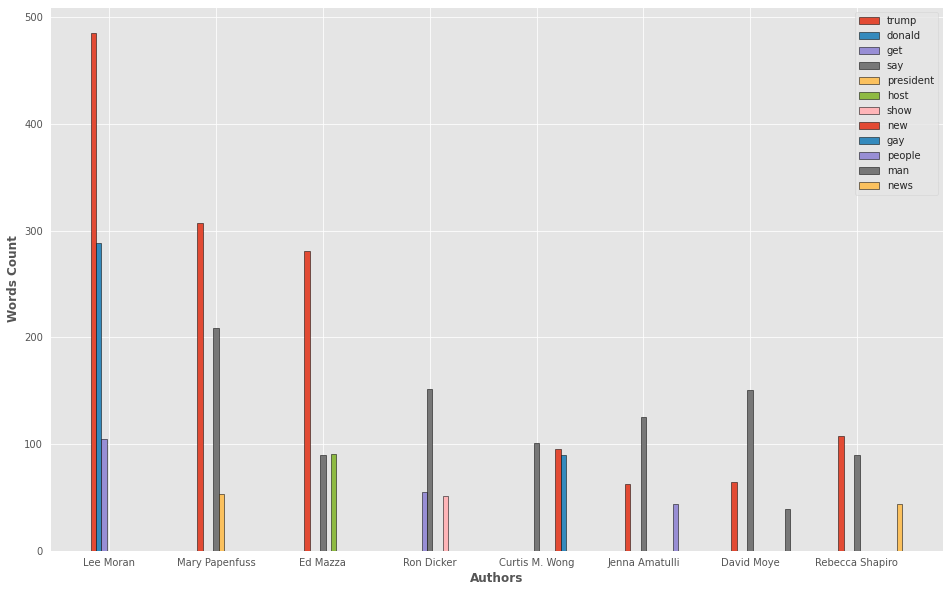

In [50]:
plot_bars_authors(words_df = word_df, authors_df = aut_words_df)

## Fifth point

Targets and labels for new training

In [51]:
# Visualizing short description
# Use plotly to see the distribution of categorical data
# https://www.kaggle.com/vikashrajluhaniwal/recommending-news-articles-based-on-read-articles#6.-Headline-based-similarity-on-new-articles
fig = ff.create_distplot([news_category['short_description'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Description lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of Description",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500)
plotly.offline.plot(fig, filename = 'short_description.html')

'short_description.html'

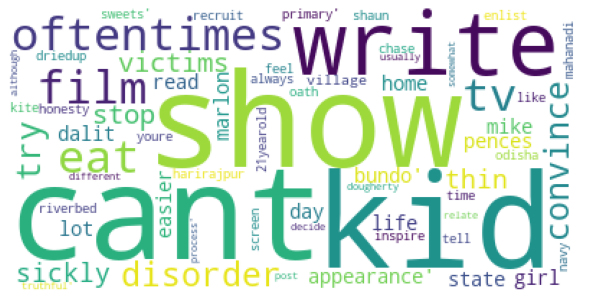

In [52]:
# Make a copy of the dataset
shortd_df = f_articles.copy()

text_description = shortd_df['short_description'].values 
wordcloud = WordCloud(max_words = 200, background_color ='white', stopwords = stop_words).generate(str(text_description))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [53]:
# Targets
seq_des = np.array([text for text in f_articles['short_description']])
# Labels
labels_des = np.array([label for label in f_articles['category']])

In [54]:
print(seq_des.shape)
print(seq_des[0])

(24274,)
oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance


In [55]:
# Encoding categories
label_encoder_des = LabelEncoder()
# Fir the encoder
labels_des = label_encoder_des.fit_transform(labels_des)

In [56]:
print('The lenght of the labels are: {}'.format(len(np.unique(labels_des))))
print('The labels are: {}'.format(np.unique(labels_des)))

The lenght of the labels are: 28
The labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [57]:
# Parameters
# Size of the vocabulary
vocab_size = 2000
# Dimmension of the embedding 
embedding_dim = 128
# LSTM dim
lstm_dim = 32
# hidden dim (fully connected)
hidden_dim = 64
# Maximum lenght of the tokenized vector
max_length = 120
# Padd the vector after the sequence
padding_type ='post'
# Used to replace out-of-vocabulary words
oov_tok = "<OOV>"

In [58]:
# split the dataset
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(seq_des, labels_des, 
                                                                                          test_size = 0.33, 
                                                                                          stratify = labels_des)

In [59]:
# Transform text into a vector
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fir to the train sequence
tokenizer.fit_on_texts(train_sentences)
# Dictionary with the index of each word
word_index = tokenizer.word_index

# Transform train dataset to sequence 
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# Pad the sequence to the desired shape (given above)
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)

# Vectorize and Padd validation dataset
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen = max_length)

In [60]:
type(train_padded)

numpy.ndarray

In [61]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Flat Dimension
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)), # Output of LSTM is Batch x Net out x 2
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels_des)), activation='softmax')
])

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 128)          256000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 28)                1820      
Total params: 303,196
Trainable params: 303,196
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
# Callback for early stopping after val stop improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
num_epochs = 50
history = model.fit(train_padded, train_labels, 
                    epochs = num_epochs, verbose=2, 
                    validation_split=0.33, callbacks= [early_stop])

# Predict over the validation test
pred_val = model.predict(validation_padded)
pred_val = np.array([np.argmax(i) for i in pred_val])

Epoch 1/50
341/341 - 6s - loss: 2.3989 - accuracy: 0.3764 - val_loss: 2.2421 - val_accuracy: 0.4043
Epoch 2/50
341/341 - 6s - loss: 2.0917 - accuracy: 0.4396 - val_loss: 2.1306 - val_accuracy: 0.4379
Epoch 3/50
341/341 - 6s - loss: 1.8904 - accuracy: 0.4891 - val_loss: 2.1239 - val_accuracy: 0.4449
Epoch 4/50
341/341 - 6s - loss: 1.7279 - accuracy: 0.5201 - val_loss: 2.1390 - val_accuracy: 0.4300
Epoch 5/50
341/341 - 5s - loss: 1.5819 - accuracy: 0.5551 - val_loss: 2.2193 - val_accuracy: 0.4401
Epoch 6/50
341/341 - 5s - loss: 1.4500 - accuracy: 0.5894 - val_loss: 2.2675 - val_accuracy: 0.4313


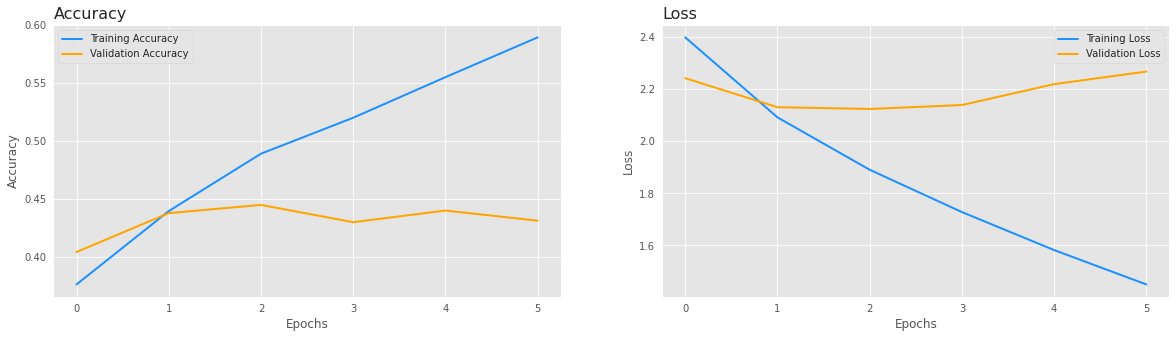

In [63]:
# Plotting the history of the model
plot_history(history)

The overall training accuracy is: 0.4344026962925977


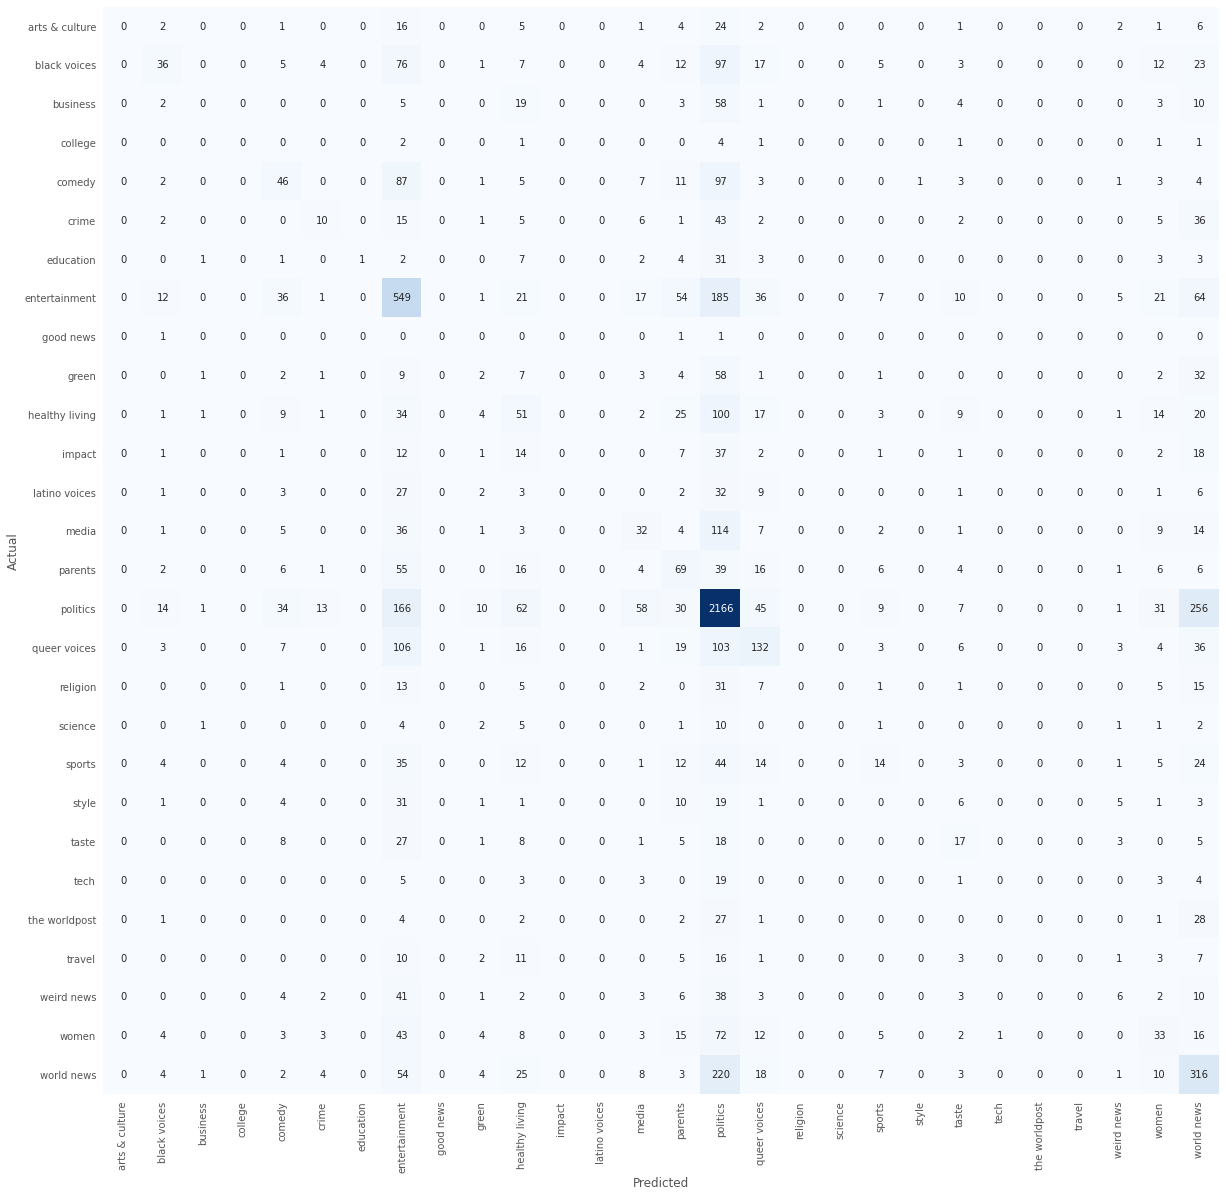

In [64]:
# Confusion matrix
# label_encoder.classes_ show the classes encoded
print('The overall training accuracy is: {}'.format(accuracy_score(pred_val, validation_labels)))
plot_cmatrix(pred_val, label_encoder_des.classes_, 20, validation_labels)

In [65]:
# Printing all the metrics
print(classification_report(pred_val, validation_labels, target_names = label_encoder_des.classes_))

                precision    recall  f1-score   support

arts & culture       0.00      0.00      0.00         0
  black voices       0.12      0.38      0.18        94
      business       0.00      0.00      0.00         6
       college       0.00      0.00      0.00         0
        comedy       0.17      0.25      0.20       182
         crime       0.08      0.25      0.12        40
     education       0.02      1.00      0.03         1
 entertainment       0.54      0.38      0.44      1464
     good news       0.00      0.00      0.00         0
         green       0.02      0.05      0.02        40
healthy living       0.17      0.16      0.17       324
        impact       0.00      0.00      0.00         0
 latino voices       0.00      0.00      0.00         0
         media       0.14      0.20      0.17       158
       parents       0.30      0.22      0.26       309
      politics       0.75      0.58      0.66      3703
  queer voices       0.30      0.38      0.33  

/home/sherlock/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [66]:
class_correct = list(0. for i in range(len(np.unique(labels_des))))
class_total = list(0. for i in range(len(np.unique(labels_des))))
# For loop to count the number of matches per class
for i in range(len(validation_labels)):
    # current target's label
    label = validation_labels[i]
    if validation_labels[i] == pred_val[i]:
        class_correct[label] += 1
    # Sum label
    class_total[label] += 1
        
for i in range(len(np.unique(labels_des))):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(label_encoder_des.classes_[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Accuracy of arts & culture:  0% ( 0/65)
Test Accuracy of black voices: 11% (36/302)
Test Accuracy of business:  0% ( 0/106)
Test Accuracy of college:  0% ( 0/11)
Test Accuracy of comedy: 16% (46/271)
Test Accuracy of crime:  7% (10/128)
Test Accuracy of education:  1% ( 1/58)
Test Accuracy of entertainment: 53% (549/1019)
Test Accuracy of good news:  0% ( 0/ 3)
Test Accuracy of green:  1% ( 2/123)
Test Accuracy of healthy living: 17% (51/292)
Test Accuracy of impact:  0% ( 0/97)
Test Accuracy of latino voices:  0% ( 0/87)
Test Accuracy of media: 13% (32/229)
Test Accuracy of parents: 29% (69/231)
Test Accuracy of politics: 74% (2166/2903)
Test Accuracy of queer voices: 30% (132/440)
Test Accuracy of religion:  0% ( 0/81)
Test Accuracy of science:  0% ( 0/28)
Test Accuracy of sports:  8% (14/173)
Test Accuracy of style:  0% ( 0/83)
Test Accuracy of taste: 18% (17/93)
Test Accuracy of  tech:  0% ( 0/38)
Test Accuracy of the worldpost:  0% ( 0/66)
Test Accuracy of travel:  0% ( 0/59)

## Fourth Point

In [67]:
# Clustering Algorithm
# http://brandonrose.org/clustering
from sklearn.cluster import KMeans
# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
# Targets
seq_text = np.array([text for text in f_articles['full_text']])
# Labels
labels = np.array([label for label in f_articles['category']])

In [69]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(seq_text)

In [70]:
 vectorizer.get_feature_names()

['00',
 '000',
 '0002',
 '007',
 '0075',
 '01',
 '02',
 '05k',
 '06290177',
 '0for5',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '1000perchild',
 '1000x',
 '100500',
 '100day',
 '100footlong',
 '100meter',
 '100mile',
 '100s',
 '100th',
 '100year',
 '101',
 '101st',
 '101yearold',
 '102',
 '103',
 '1030',
 '104',
 '105',
 '1052',
 '10565',
 '105th',
 '106yearold',
 '107',
 '1074',
 '109',
 '1091',
 '10day',
 '10episode',
 '10k',
 '10mile',
 '10minute',
 '10month',
 '10page',
 '10point',
 '10pound',
 '10s',
 '10th',
 '10year',
 '10yearold',
 '11',
 '110',
 '1100',
 '11000',
 '1105',
 '110mile',
 '110pound',
 '111',
 '111th',
 '112',
 '112000',
 '112th',
 '112yearold',
 '113',
 '1130',
 '114',
 '1140',
 '115pound',
 '1166',
 '116700',
 '116th',
 '117',
 '119',
 '11dayold',
 '11game',
 '11hour',
 '11th',
 '11thgrade',
 '11year',
 '11yearold',
 '12',
 '120',
 '1200',
 '12000',
 '120000',
 '121',
 '121000',
 '1218',
 '122',
 '123',
 '124000',
 '125',
 '1250',
 '125000',
 '125pound',
 '12

In [71]:
number_of_clusters = 20
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init=1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
model.fit(X)

KMeans(max_iter=100, n_clusters=20, n_init=1)

In [72]:
# Obtain the indexes of the clusters' features from maximum to minumum 
# Index of words
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [73]:
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 new
 make
 like
 kid
 parent
 day
 come
 best
 im
 life
Cluster 1:
 white
 house
 trump
 say
 supremacists
 president
 donald
 charlottesville
 press
 staff
Cluster 2:
 say
 state
 right
 school
 vote
 court
 man
 kill
 election
 police
Cluster 3:
 think
 trump
 say
 people
 americans
 donald
 really
 make
 like
 kid
Cluster 4:
 attack
 trump
 say
 kill
 terror
 london
 manchester
 terrorist
 president
 police
Cluster 5:
 trump
 donald
 president
 say
 administration
 russia
 tweet
 make
 campaign
 presidents
Cluster 6:
 know
 trump
 need
 say
 dont
 want
 things
 like
 really
 im
Cluster 7:
 gun
 shoot
 school
 violence
 mass
 control
 police
 florida
 vegas
 say
Cluster 8:
 love
 say
 people
 trump
 mom
 new
 make
 like
 life
 letter
Cluster 9:
 north
 korea
 korean
 south
 trump
 nuclear
 missile
 kim
 jong
 say
Cluster 10:
 health
 care
 tax
 gop
 senate
 republicans
 plan
 repeal
 obamacare
 cut
Cluster 11:
 climate
 change
 paris
 trump
 say
 agreement
 global
 epa
 w

In [74]:
test_x = vectorizer.transform(['I hate people all the time'])
cluster = model.predict(test_x)[0]
print("Text belongs to cluster number {0}".format(cluster))

Text belongs to cluster number 16


In [75]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters